# Doomed to failure: A story about target encoding and Tree-Based Algorithms
---

Have you ever worked with target encoders? Did you ever use any tree-based model? If you have worked with either there will likely be a time in which you are tempted to use both in the same pipeline for classifying data points with categorical features. DON'T! At least until you have read this article detailing one dangerous caveat that this combination has.

In this article, I will guide you through the caveats that appear when a pipeline combines certain members of the family of target encoders with tree-based models and extremely low or high entropy features. I'll clue you in: data leakeages and overfitting issues will break your pipeline's performance.

The discussion will be centered around the most basic target encoder and the leave-one-out encoder and their interaction with tree-based models under certain conditions. Ultimately, it will lead towards a justification to use CatBoost under these same conditions.

The good news is that these problems that we will see are easy to solve - just use CatBoost and let it handle the encoding methodology for you. As I will be arguing the encoder that it uses by default for categorical features magnificently handles categorical fetures with both extremely low and high entropies and is still in the realm of target encoding.

**Important: to simplify the discussion we will frame the discussion under a binary classification task.**


#### Package Imports

In [ ]:
import category_encoders as ce
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.pipeline import Pipeline

## Background Knowledge

### Encoders

Encoding methodologies aim to transform non-numerical categorical feature values into numerical values. There are multiple approaches and each comes with its own advantages and caveats. For instance, to mention a few of them:

- **Label Encoding**: it simply assigns a unique integer to each category in the data.
    *Pros:*
    1. Simple

    *Cons:*
    1. May introduce ordinal relationships
    2. Features with unknown amounts of categories which have high amounts of low-frecquency categories may be clustered into a marginal category, loosing predictive power based on them.

- **One-Hot Encoding**: for each category seen for a feature, it creates a new dummy feature which simply indicates with 0 or 1 when the category appears.
    *Pros:*
    1. Simple
    2. Does not assume order between categories

    *Cons:*
    1. Dimensionality may increase considerably making the use of a dimensionality reduction technique necessary and potentially exploding your system's memmory (tip: if you still want to use it check sparse matrices).
    2. Computationally expensive.
    3. Features with unknown amounts of categories which have high amounts of low-frecquency categories may be clustered into a marginal category, loosing predictive power based on them.

- **Binary Encoding, Hashing Encodings and more. Let's not get carried out into an endless enumeration.**

Importantly, encoding methodologies and classifier interact in different ways and consequently the resulting pipelines may inherit or develop different properties and caveats. 

### Target Encoders

In its most basic form, a target encoder substitutes each category $c$ of a feature with the training set statistic 
$$stat = \frac{N_{positive\_samples\_with\_category\_c\_for\_the\_feature}}{N_{all\_samples\_with\_category\_c\_for\_the\_feature}}$$

Let us see this basic encoder in action with a basic custom implementation. Firstly, we create a trivial dataset:

In [23]:
dataset_1 = pd.DataFrame(
    {
        "feature_1": ["A", "A", "A", "B", "B", "C"],
        "target": [0, 1, 0, 1, 0, 1],
    }
)
dataset_1

,feature_1,target
0,A,0
1,A,1
2,A,0
3,B,1
4,B,0
5,C,1


Then, we implement the encoding of the categories according to the most basic target encoder:

In [19]:
categories = dataset_1.feature_1.unique()
stats_map = {
    category: dataset_1[dataset_1.feature_1 == category].target.mean() for category in categories
}
dataset_1["feature_1_encoded"] = dataset_1.feature_1.map(stats_map)
dataset_1

,feature_1,target,feature_1_encoded
0,A,0,0.333333
1,A,1,0.333333
2,A,0,0.333333
3,B,1,0.500000
4,B,0,0.500000
5,C,1,1.000000


The resulting encoded feature is the only one used by ML algorithms. The idea is that we can actually encode features by their tendency to be associated with the positive class. This way an algorithm learns on top of the tendencies seen for all features, "weights" them and is able to generalize on nobel data points

Nevertheless, note that the encoded value for C has quite a strong meaning taking into account that we have only one instance of it (I know: the other categories are nearly as scarce from the statistical perspective). In other words, C could actually be a lucky sample and in reality C could actually be more associated with zero labels. Good catch! Actually, this first encoder comes with its own caveat: it is easy to overfit based on scarce categories. 

Therefore, many versions arised to distill this knowledge about category frecquency into the encodings. The most common approach is to simply perform a smoothing between the prior prevalence computed over the training set and the target statistic. For instance, the target encoding from the category-encoders library uses the smoothing:
$$enc(category) = p * stat + (1 - p) * prevalence$$
where the prevalence is defined by:
$$prevalence = \frac{N_{positives}}{N}$$
and the weighting constant is obtained by:
$$p = \frac{1}{1 + \exp\big(\frac{(-n\_{value} - k)}{f}\big)}$$
In the last equation, $k$ and $f$ are respectively called the minimum samples per leaf and smoothing parameters. To get further information checkout their [documentation](https://contrib.scikit-learn.org/category_encoders/targetencoder.html).

#### Leave-one-out Encoder

As previously mentioned, there are multiple types of target encoders and sometimes different resources name them differently. However, the last encoder in the previous section is usually the one receiving the name of target encoder. An encoder in this big family that is commonly used is the so-called leave-one-out Encoder. The methodology that it uses aims to signal outlier category-to-label instances and reduce their impact in the general target statistic computation. It is frequently used by data scientists. As we will see it comes with several caveats. However, let us see how it works first!

The leave-one-out encoder is actually a vanila target encoder. However, it has a slight modification: it works differently when fitting and transforming the encoder to the training data in comparison when it transforms data from the validation or test sets and new inference data. That is:

- When fitting and transforming training data: to compute the encoding of a category c for sample i, we compute the target statistic without accounting for the ith sample
- When transforming data once the encoder has been fitted, the encoder works as the most basic vanila target encoder.

The goal of this approach is to ensure that the classifier can learn about categories during training without the encodings being too influenced by outliers. Up next, we show how it works for our dummy dataset while simultaneously comparing it with the target encoder.

In [20]:
target_encoder = ce.TargetEncoder()
loo_encoder = ce.LeaveOneOutEncoder()

If we look at the resulting transformation performed by the leave-one-out encoder on the training set (done with the **fit_transform** method) we see the following:

In [21]:
loo_encoder.fit_transform(dataset_1[["feature_1"]], dataset_1["target"])

,feature_1
0,0.5
1,0.0
2,0.5
3,0.0
4,1.0
5,0.5


whereas transformation that it does for any dataset that are passed once it is fitted (only calling the **transform** method) are different since the leaving-one-out methodology is no longer applied:

In [22]:
loo_encoder.transform(dataset_1[["feature_1"]])

,feature_1
0,0.333333
1,0.333333
2,0.333333
3,0.500000
4,0.500000
5,0.500000


Note the following three things:

1. Category C only appears once, and consequently we do not want its encoding to be highly influential during training. The leaving-one-out methodology achieves this by simply substituting C with the prevalence of the training data since by leaving it out, we do not have any sample to compute the target statistic and consequenly default to the prevalence: 0.5.

2. The outlier sample in terms of the category-to-target relationship for category A was encoded differently during training i.e. it was replaced by 0 instead of 0.5.

3. Indeed the encoder transforms categories differently once it has been fitted (actually, if you think about it: it is impossible to run the leaving-one-out methodology on inference data since you do not the label).

You may also notice another fact: feature_1 kind of sucks in order to predict target labels from it. It's okay, we only want to use this dummy dataset to show the inner workings of these encoders.

To demonstrate the third point, we can see that the target encoder indeed always performs the same encoding:

In [24]:
target_encoder.fit_transform(dataset_1[["feature_1"]], dataset_1["target"])

,feature_1
0,0.474256
1,0.474256
2,0.474256
3,0.500000
4,0.500000
5,0.565054


In [26]:
target_encoder.transform(dataset_1[["feature_1"]])

,feature_1
0,0.474256
1,0.474256
2,0.474256
3,0.500000
4,0.500000
5,0.565054


## Mixing Tree-based Models and Target Encoders: Failure Scenarios

> *A smooth sea never made a skilled sailor*

At this point you have read through the definitions of the vanila target encoder and the leave-one-out encoder, and might be tempted to start using it with powerfull tree-based classifiers like Random Forests. ⚠️WATCH OUT!⚠️ As you will see in the following set of scenarios, under certain conditions this combination can be fatal and lead to the massive overfitting of the training dataset.

These are basically two scenarios: 

- Scenario 1: Leave-one-out Encoder + feature with a highly frecquent category that is uncorrelated to the target variable + Decision Tree -> Data Leak

- Scenario 2: Target Encoder + feature with a large set of unique categories that have low frequency + Decision Tree -> Data Leak 


### Scenario 1: Leave-one-out Encoder + feature with a highly frecquent category that is uncorrelated to the target variable + Decision Tree

To showcase this failure scenario, we will use a new dummy dataset which contains only one feature and the target. For your information, this feature will always have the same categorical value and consequently the target random variable and the feature random variable are independent. In fact, this means that you can't use that feature to make that prediction and that you might need to collect new features. 


In [37]:
dataset_2 = pd.DataFrame(
    {
        "independent_feature": ["a"] * 10,
        "target": [0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
    },
)
dataset_2

,independent_feature,target
0,a,0
1,a,1
2,a,0
3,a,1
4,a,0
5,a,1
6,a,0
7,a,1
8,a,0
9,a,1


It is clear that this feature has a category $a$ which not only is uncorrelated but also is highly frecquent. The problem that appears from having this kind of features when using the leave-one-out encoder and a tree-based model appears when during training, the leave-one-out methodology leaks information about the target variable into the encodings of the feature. 

We can illustrate why this happens with the above dataset. The reason is that if we have n samples with category a and out of these there are m samples that have a target of 1, then if we are encoding the category of a sample with target 1, then we get the statistic: $$\frac{m-1}{n-1}$$ whereas if the sample is associated with label 0 then we get the statistic: $$\frac{m}{n-1}$$

Therefore, the encoding itself is somehow copying all the information about the target variable needed to correctly predict on all samples from the training set. As a mater of fact, we can see that this happens for our dataset:

In [34]:
loo_encoder = ce.LeaveOneOutEncoder()
encoded_data = loo_encoder.fit_transform(dataset_2[["independent_feature"]], dataset_2["target"])
encoded_data


,independent_feature
0,0.555556
1,0.444444
2,0.555556
3,0.444444
4,0.555556
5,0.444444
6,0.555556
7,0.444444
8,0.555556
9,0.444444


It is no mistery that a simple decision tree can the perfectly fit the training dataset since it is able to build a hyperplane separating both encodings. 
As a matter of fact: 

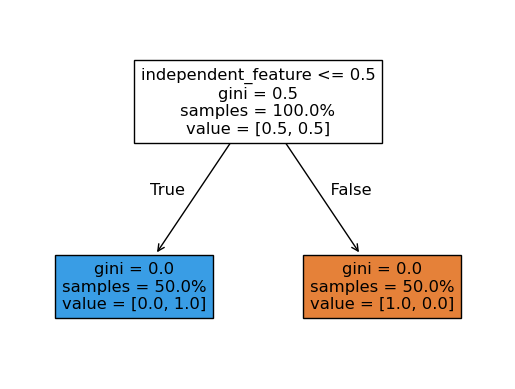

In [35]:
tree = DecisionTreeClassifier().fit(encoded_data, dataset_2["target"])
figure = plot_tree(
    tree,
    proportion=True,
    filled=True,
    feature_names=["independent_feature"],
)

which shows a perfect fit on the training set even though we know that since the feature and the target are independent this tree would then yield poor results for newly sampled data points.

Why not just drop the feature and use others in the data set? I mean: Shouldn't this feature be dropped on the EDA part of the project? Well the answer is that this example is exagerating the presence of the category and consequently its impact. Nevertheless, this impact still happens for milder instances of this same scenario. For instance, if we have that a feature has for 80% of the training data the same categorical value which is uninformative about the target variable, then this phenomenon will happen but only affect this 80% of the dataset. However, if it turns out that for the rest of the dataset the same happens for another feature, then we are doomed to failure as well.

Notice that this would not happen for other encoders. Nevertheless all projects are unique and their particularities may also yield other encoders useless. Hence, it is good to know that we can still use this kind of encoders (we will show it in the future). Additionally, even though it is highly not recommended you might not have information about all the possible features that you can have in the training data but you may still want to use as much information as you can while delegating the triage of useless and usefull features to your encoder + classifier pipeline. Again, although this can happen I would not recommend it since you may incur in unexpected errors. 

### Scenario 2: Target Encoder + feature with a large set of unique categories that have low frequency + Decision Tree -> Data Leak
